In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
my_random_state = 10

bcw_data = pd.read_csv('./breast-cancer-prepared.csv')
bcw_data.sample(5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,is_malignant
296,10.91,12.35,69.14,363.7,0.08518,0.04721,0.012360,0.013690,0.1449,0.06031,...,14.82,72.42,392.2,0.09312,0.07506,0.02884,0.03194,NaN,0.06643,0
361,13.30,21.57,85.24,546.1,0.08582,NaN,0.033440,0.024240,0.1815,0.05696,...,29.20,92.94,621.2,0.11400,0.16670,0.12120,0.05614,0.2637,0.06658,0
249,11.52,14.93,73.87,406.3,0.10130,0.07808,0.043280,0.029290,0.1883,0.06168,...,21.19,80.88,491.8,0.13890,0.15820,0.18040,NaN,0.2664,0.07809,0
334,12.30,19.02,77.88,464.4,0.08313,NaN,0.007756,0.008535,0.1539,0.05945,...,28.46,84.53,544.3,0.12220,0.09052,0.03619,0.03983,0.2554,0.07207,0
400,17.91,21.02,124.40,994.0,0.12300,0.25760,0.318900,0.119800,0.2113,0.07115,...,27.78,149.60,1304.0,0.18730,0.59170,0.90340,0.19640,0.3245,0.11980,1


## Random Forst Classification

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [41]:
X = bcw_data[bcw_data.columns[:-1]]
y = bcw_data['is_malignant']

# Identify columns with missing values
cols_with_missing_vals = [c for c in X.columns if X[c].isnull().any()]

In [ ]:
# Split into train, validation, and test sets (70%-15%-15%)

X_train, X_test_full, y_train, y_test_full = train_test_split(X, y, 
                                                             random_state=my_random_state, 
                                                             test_size=0.3, 
                                                             stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test_full, y_test_full, 
                                               random_state=my_random_state, 
                                               test_size=0.5, 
                                               stratify=y_test_full)

In [ ]:
# Apply imputation with flags
simple_imputer = SimpleImputer(strategy='mean')

X_train_imputed_plus = X_train.copy()
X_val_imputed_plus = X_val.copy()
X_test_imputed_plus = X_test.copy()

In [44]:
# Add flag columns for missing values
for curr_col in cols_with_missing_vals:
    X_train_imputed_plus[curr_col + '_was_missing'] = X_train_imputed_plus[curr_col].isnull()
    X_val_imputed_plus[curr_col + '_was_missing'] = X_val_imputed_plus[curr_col].isnull()
    X_test_imputed_plus[curr_col + '_was_missing'] = X_test_imputed_plus[curr_col].isnull()

# Impute missing values
X_train_imputed_plus[cols_with_missing_vals] = simple_imputer.fit_transform(X_train_imputed_plus[cols_with_missing_vals])
X_val_imputed_plus[cols_with_missing_vals] = simple_imputer.transform(X_val_imputed_plus[cols_with_missing_vals])
X_test_imputed_plus[cols_with_missing_vals] = simple_imputer.transform(X_test_imputed_plus[cols_with_missing_vals])

In [45]:
# Create a function to find the best n_estimators (number of trees)
def find_best_n_estimators(X_train, X_val, y_train, y_val, do_print=True):
    result = None
    accuracy_max = -1
    
    for n_trees in [10, 50, 100, 200, 300]:
        rf_model = RandomForestClassifier(n_estimators=n_trees, random_state=my_random_state)
        rf_model.fit(X_train, y_train)
    
        y_pred = rf_model.predict(X_val)
        accuracy_score_val = accuracy_score(y_val, y_pred)
        
        if accuracy_score_val >= accuracy_max:
            accuracy_max = accuracy_score_val
            result = n_trees
        
        if do_print:
            print(f'n_estimators {n_trees}: {accuracy_score_val:.5%} accuracy on validation set.')
    
    if do_print:
        print('-' * 20)
        print(f'Best n_estimators {result} has {accuracy_max:.5%} accuracy.')
    
    return result

# Find the best number of trees
best_n_estimators = find_best_n_estimators(X_train_imputed_plus, X_val_imputed_plus, y_train, y_val)

n_estimators 10: 96.47059% accuracy on validation set.
n_estimators 50: 96.47059% accuracy on validation set.
n_estimators 100: 96.47059% accuracy on validation set.
n_estimators 200: 96.47059% accuracy on validation set.
n_estimators 300: 96.47059% accuracy on validation set.
--------------------
Best n_estimators 300 has 96.47059% accuracy.


In [46]:
# Train the final Random Forest model with the best n_estimators
rf_model = RandomForestClassifier(n_estimators=best_n_estimators, random_state=my_random_state)
rf_model.fit(X_train_imputed_plus, y_train)

RandomForestClassifier(n_estimators=300, random_state=10)

In [47]:
y_val_pred = rf_model.predict(X_val_imputed_plus)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy: {val_accuracy:.2%}")

Validation accuracy: 96.47%


In [48]:
y_test_pred = rf_model.predict(X_test_imputed_plus)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy: {test_accuracy:.2%}")

Test accuracy: 91.86%


In [49]:
dt_accuracy = 0.9419  # Based on the notebook's conclusion
print(f"\nRandom Forest test accuracy: {test_accuracy:.2%}")
print(f"Decision Tree test accuracy: {dt_accuracy:.2%}")
print(f"Difference: {test_accuracy - dt_accuracy:.2%}")


Random Forest test accuracy: 91.86%
Decision Tree test accuracy: 94.19%
Difference: -2.33%


In [50]:
# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93        54
           1       0.88      0.91      0.89        32

    accuracy                           0.92        86
   macro avg       0.91      0.92      0.91        86
weighted avg       0.92      0.92      0.92        86



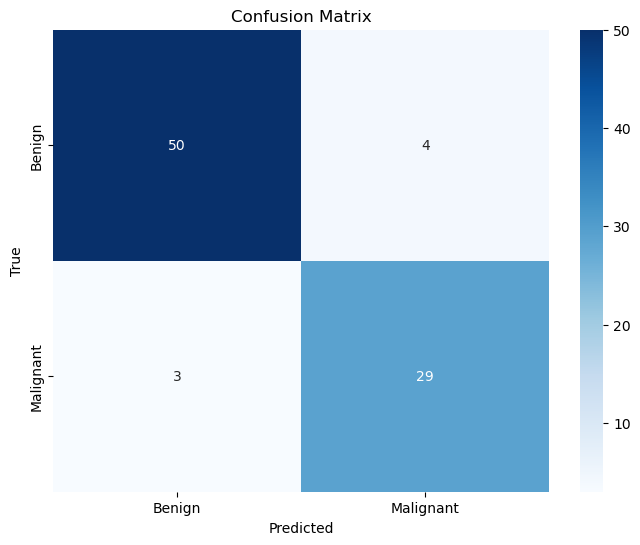

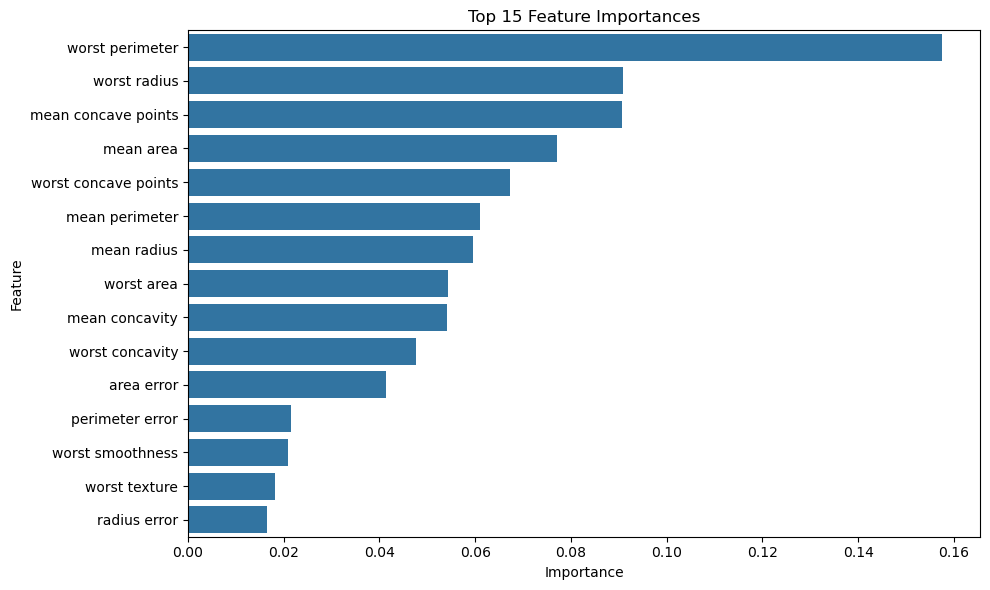

In [51]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': X_train_imputed_plus.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

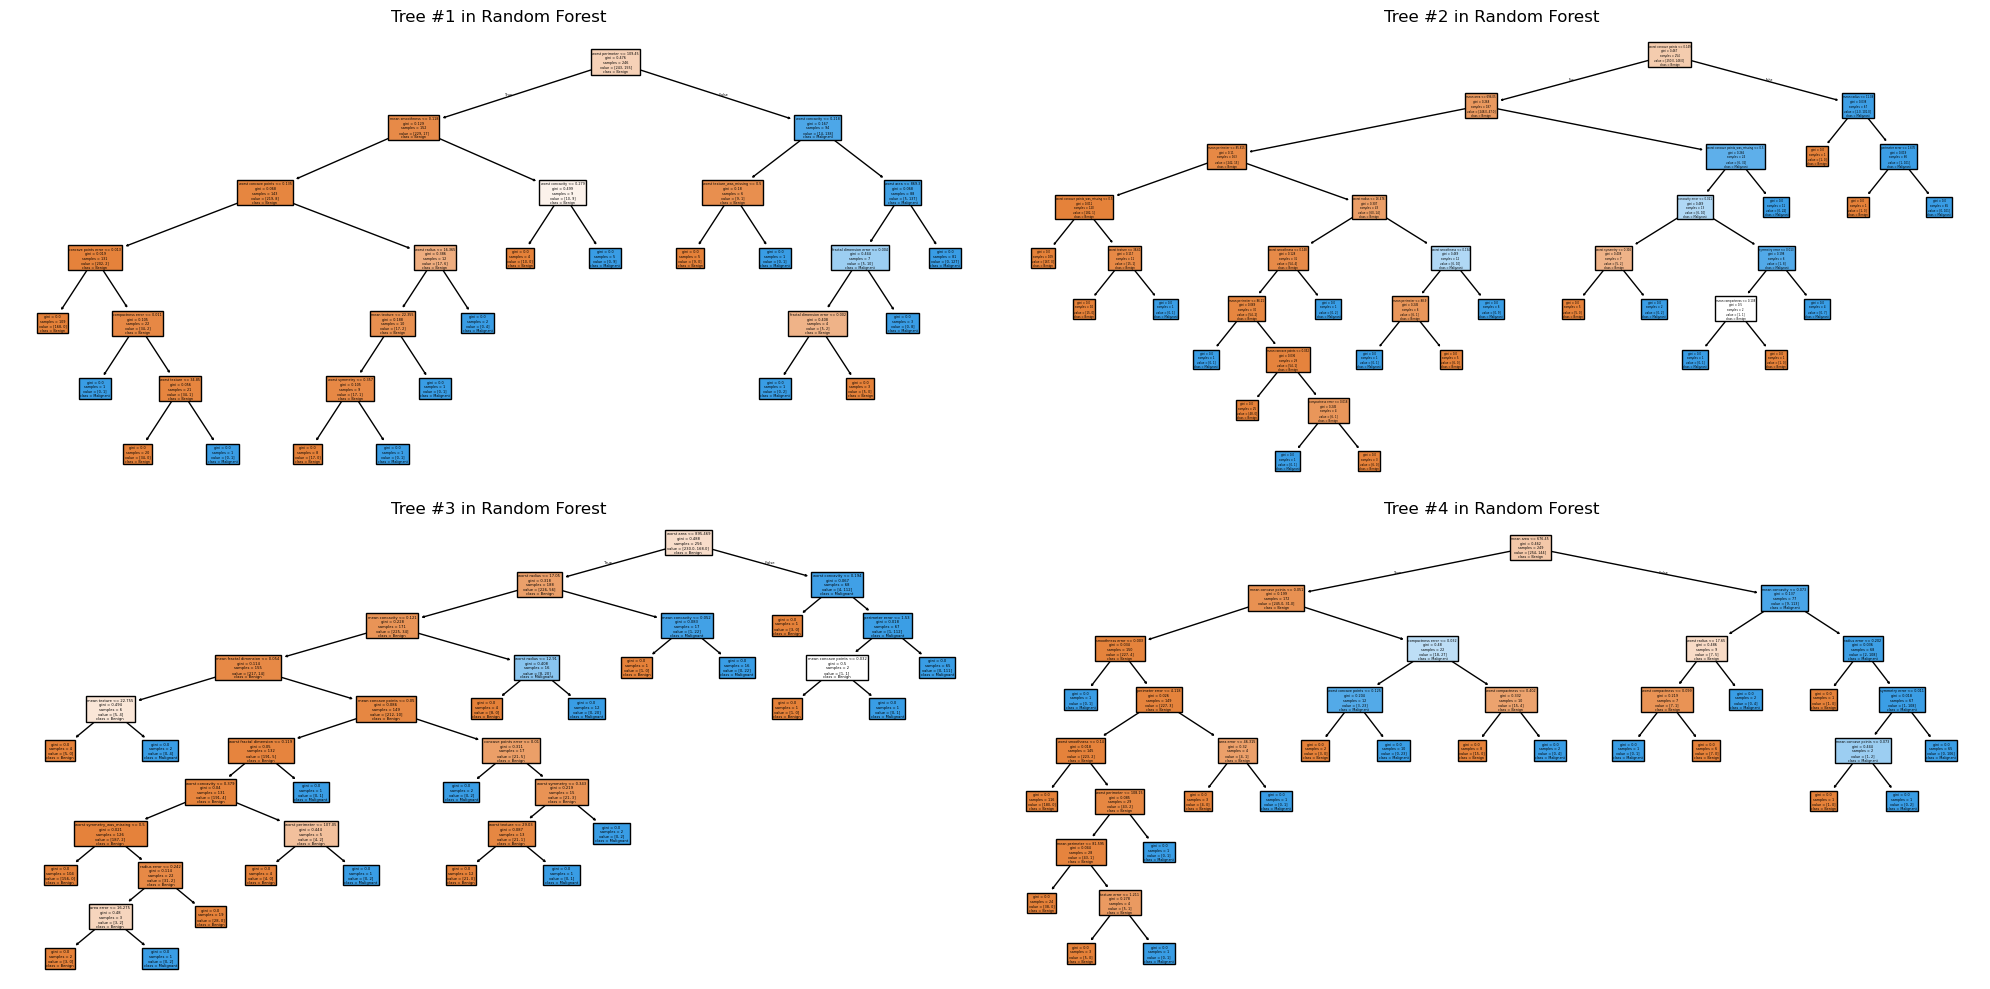

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt
import math

# Function to plot a sample of trees from the forest
def plot_forest_sample(forest, feature_names, class_names, n_trees=4):
    n_rows = math.ceil(n_trees / 2)
    _, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(20, 5*n_rows))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if i < n_trees:
            tree.plot_tree(
                forest.estimators_[i],
                feature_names=feature_names, 
                class_names=class_names,
                filled=True,
                ax=ax
            )
            ax.set_title(f'Tree #{i+1} in Random Forest')
        else:
            ax.set_visible(False)
    
    plt.tight_layout()
    plt.show()

# After training the Random Forest model:
# Visualize a sample of trees
feature_names = X_train_imputed_plus.columns.tolist()
class_names = ['Benign', 'Malignant']

plot_forest_sample(rf_model, feature_names, class_names, n_trees=4)

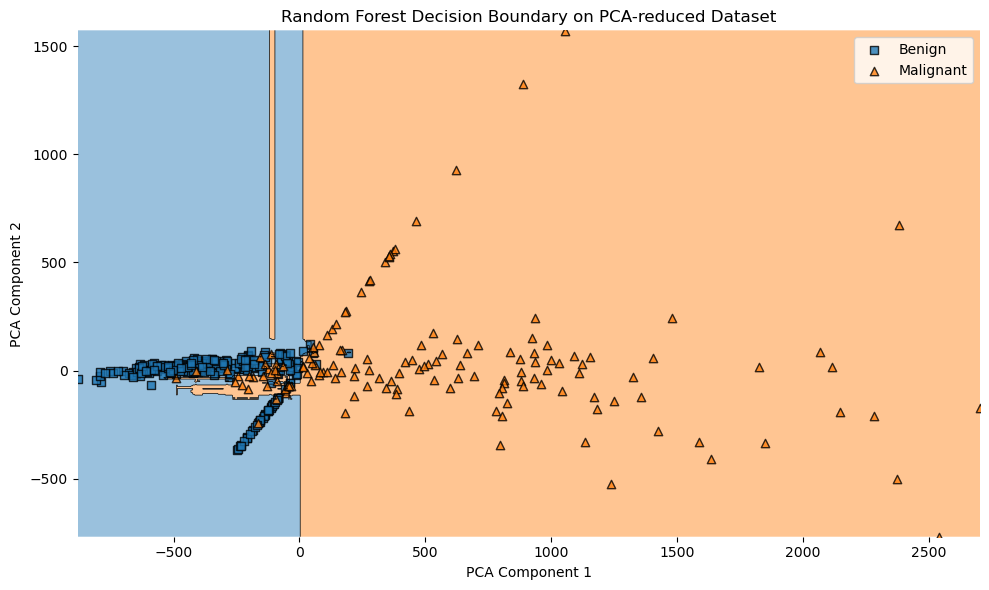

In [53]:
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions

# Use PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_imputed_plus)
X_test_pca = pca.transform(X_test_imputed_plus)

# Train a new Random Forest on the reduced dataset for visualization
rf_viz = RandomForestClassifier(n_estimators=best_n_estimators, random_state=my_random_state)
rf_viz.fit(X_train_pca, y_train)

# Prepare a meshgrid for visualization
def plot_decision_boundary(X, y, model, title):
    plt.figure(figsize=(10, 6))
    
    # Plot decision boundary
    plot_decision_regions(X, y.values.astype(np.int32), clf=model, legend=2)
    
    # Add axis labels and title
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(title)
    
    # Add legend with custom labels
    plt.legend(['Benign', 'Malignant', 'Decision Boundary'])
    
    plt.tight_layout()
    plt.show()

# Plot decision boundary for Random Forest
plot_decision_boundary(X_train_pca, y_train, rf_viz, 
                      'Random Forest Decision Boundary on PCA-reduced Dataset')

c:\Users\fabia\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\fabia\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\fabia\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\fabia\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\fabia\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\fabia\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier 

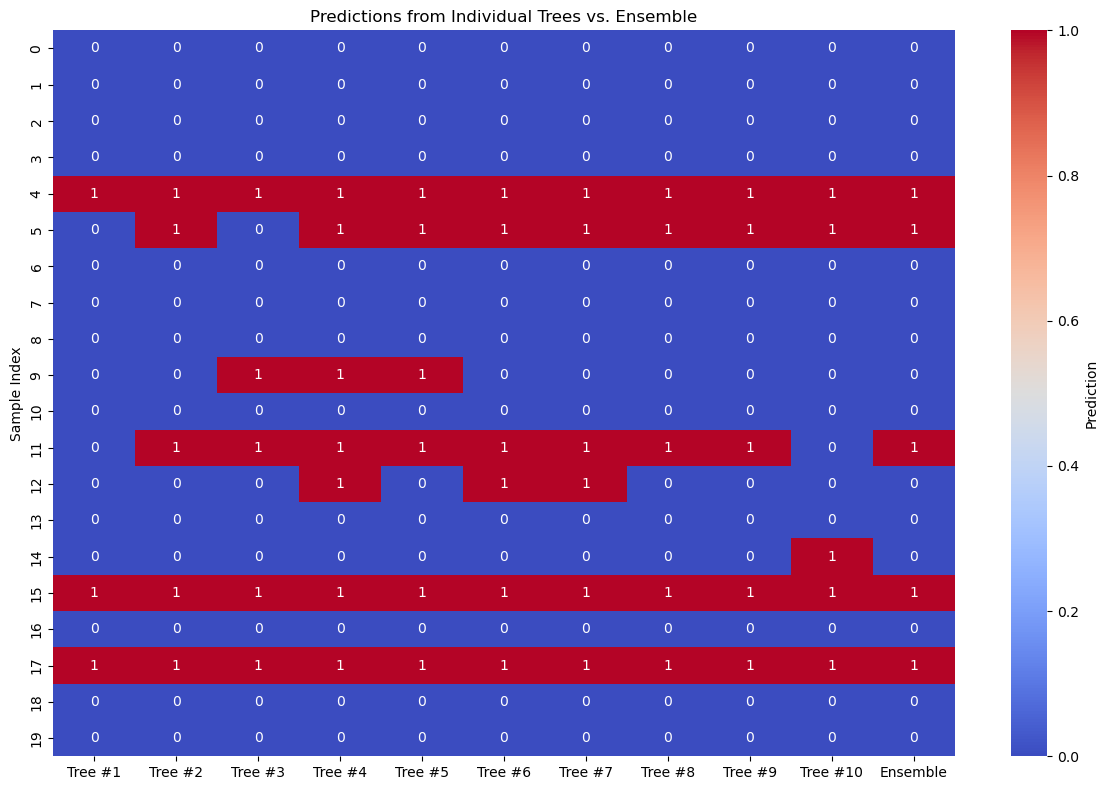

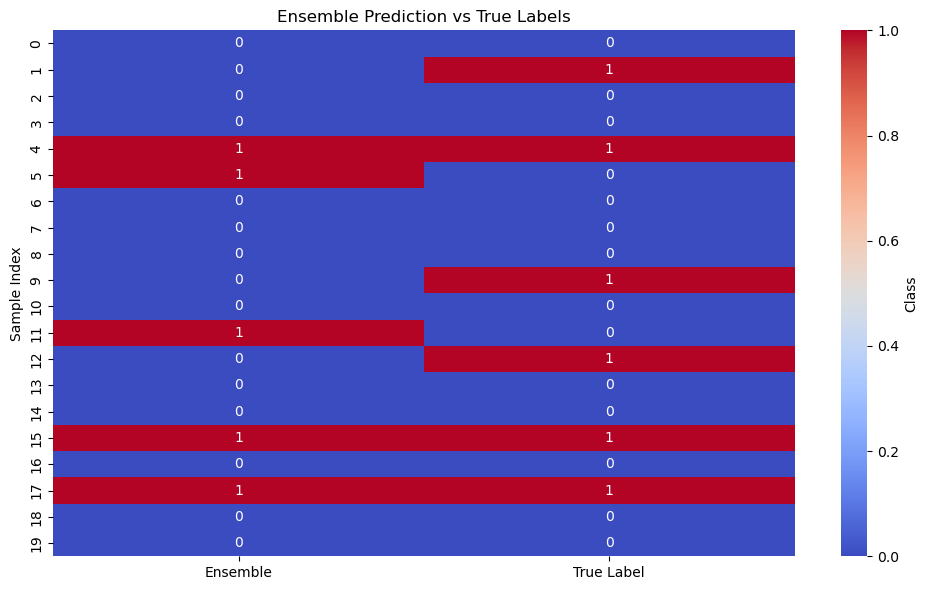

In [ ]:
# Function to visualizse prediction differences between tree
def visualize_tree_differences(forest, X_sample, n_trees=10):
    tree_predictions = []
    
    # Get predictions from individual trees
    for i in range(min(n_trees, len(forest.estimators_))):
        tree_pred = forest.estimators_[i].predict(X_sample)
        tree_predictions.append(tree_pred)
    
    # Convert to DataFrame for easier visualization
    tree_preds_df = pd.DataFrame(tree_predictions).T
    tree_preds_df.columns = [f'Tree #{i+1}' for i in range(tree_preds_df.shape[1])]
    
    # Add majority vote (ensemble prediction)
    majority_vote = np.array([np.bincount(row.astype(int)).argmax() for row in tree_preds_df.values])
    tree_preds_df['Ensemble'] = majority_vote
    
    # Add actual labels
    tree_preds_df['True Label'] = y_test.iloc[:len(X_sample)].values
    
    # Create heatmap - use .astype(int) to ensure integer formatting works
    plt.figure(figsize=(12, 8))
    sns.heatmap(tree_preds_df.iloc[:20, :-1].astype(int), 
                cmap='coolwarm', 
                annot=True, 
                fmt='d',  # Now safe to use 'd' since we converted to int
                cbar_kws={'label': 'Prediction'})
    plt.title('Predictions from Individual Trees vs. Ensemble')
    plt.ylabel('Sample Index')
    plt.tight_layout()
    plt.show()
    
    # Show comparison between ensemble prediction and true labels
    comparison_df = tree_preds_df[['Ensemble', 'True Label']].copy()
    comparison_df['Correct'] = comparison_df['Ensemble'] == comparison_df['True Label']
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(comparison_df.iloc[:20, :2].astype(int), 
                cmap='coolwarm', 
                annot=True, 
                fmt='d',
                cbar_kws={'label': 'Class'})
    plt.title('Ensemble Prediction vs True Labels')
    plt.ylabel('Sample Index')
    plt.tight_layout()
    plt.show()
    
    return tree_preds_df

# Sample a few test observations and visualize different tree predictions
tree_diff_df = visualize_tree_differences(rf_model, X_test_imputed_plus.iloc[:20], n_trees=10)

# Conclusion

We have a general accuracy of 
- Random Forest test accuracy: 91.86%
- Decision Tree test accuracy: 94.19%
- Validation accuracy: 96.47%

Compared to the other approach, we can't really see a difference, other than that the approach is a bit more complex. Even through we don't have to prepare the data as much as we did in the other approach, since we combine multiple descision trees.